Red Neuronal MLP basado en Mini-ImageNet

In [32]:
#Importar librerias necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#Verificar si hay gpu disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [33]:
# Leer class_mapping.txt y words.txt desde el directorio del dataset
class_mapping_path = r"C:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\Red Neuronal\tiny-imagenet-10\class_mapping.txt"
words_path = r"C:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\Red Neuronal\tiny-imagenet-10\words.txt"
# Crear un diccionario para mapeos de clase (índice a código)
index_to_code = {}
with open(class_mapping_path, "r") as f:
    for line in f:
        # Dividir la línea en índice y código, eliminando los elementos adicionales
        index, code = line.strip().split(": ")[0], line.strip().split(": ")[1].split(" - ")[0]
        index_to_code[int(index)] = code
# Crear un diccionario para descripciones (código a descripción)
class_descriptions = {}
with open(words_path, "r") as f:
    for line in f:
        code, description = line.strip().split("\t")  # Las líneas tienen formato 'código descripción'
        class_descriptions[code] = description
# Verificar los datos cargados
data = [
    {"Índice": index, "Código": code, "Descripción": class_descriptions[code]}
    for index, code in index_to_code.items()
]
df = pd.DataFrame(data)
print(df)

   Índice     Código                                        Descripción
0       0  n02509815  lesser panda, red panda, panda, bear cat, cat ...
1       1  n01629819    European fire salamander, Salamandra salamandra
2       2  n02395406            hog, pig, grunter, squealer, Sus scrofa
3       3  n03992509                                     potter's wheel
4       4  n02837789                                  bikini, two-piece
5       5  n03447447                                            gondola
6       6  n01984695  spiny lobster, langouste, rock lobster, crawfi...
7       7  n02791270                                         barbershop
8       8  n02206856                                                bee
9       9  n03089624          confectionery, confectionary, candy store


In [34]:
# Definir las transformaciones de los datos
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar valores de píxeles
])
# Cargar el conjunto de datos Tiny-ImageNet-10 para entrenamiento
trainset = torchvision.datasets.ImageFolder(
    root=r"C:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\Red Neuronal\tiny-imagenet-10\train",
    transform=transform
)
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
# Cargar el conjunto de datos Tiny-ImageNet-10 para prueba
testset = torchvision.datasets.ImageFolder(
    root=r"C:\Users\jhean\OneDrive\Documentos\Tareas\Inteligencia artificial\Red Neuronal\tiny-imagenet-10\test",
    transform=transform
)
test_loader = DataLoader(testset, batch_size=5, shuffle=True)  # Batch size de 5 para visualizar
# Verificar los tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(trainset)} imágenes")
print(f"Tamaño del conjunto de prueba: {len(testset)} imágenes")

Tamaño del conjunto de entrenamiento: 8000 imágenes
Tamaño del conjunto de prueba: 2000 imágenes


In [35]:
# Definir la red neuronal (MLP)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # Primera capa: 3072 entradas (3 canales * 32x32 píxeles)
        self.fc2 = nn.Linear(512, 256)         # Segunda capa: 512 entradas -> 256 salidas
        self.fc3 = nn.Linear(256, 128)         # Tercera capa: 256 entradas -> 128 salidas
        self.fc4 = nn.Linear(128, 10)          # Capa de salida: 128 entradas -> 10 clases (salidas)

    def forward(self, x):
        # Aplanar las imágenes
        x = x.view(-1, 3 * 32 * 32)  # -1 ajusta automáticamente el tamaño del lote
        # Pasar a través de las capas con activación ReLU
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # La última capa no tiene activación
        return x

# Instanciar el modelo y moverlo al dispositivo adecuado (CPU o GPU)
model = Net().to(device)

# Mostrar detalles del modelo
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [36]:
# Definir el criterio de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()  # Función de pérdida para problemas de clasificación
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Optimización con SGD

# Configurar cuDNN para mejorar el rendimiento en GPUs
torch.backends.cudnn.benchmark = True

# Mostrar configuración
print("Criterio de pérdida: CrossEntropyLoss")
print("Optimizador: SGD con tasa de aprendizaje 0.001 y momentum 0.9")

Criterio de pérdida: CrossEntropyLoss
Optimizador: SGD con tasa de aprendizaje 0.001 y momentum 0.9


In [37]:
# Obtener nombres de las clases desde el dataset
class_names = trainset.classes
print(f"Clases definidas en el conjunto de entrenamiento: {class_names}")

# Mostrar el mapeo entre índices, códigos y descripciones
print("\nMapeo de índices, códigos y descripciones:")
print(f"{'Índice':<10}{'Código':<15}{'Descripción'}")
print("-" * 45)
for i in range(10):
    code = index_to_code[i]
    desc = class_descriptions[code].split(',')[0]  # Usar solo la primera parte de la descripción para simplificar
    print(f"{i:<10}{code:<15}{desc}")

Clases definidas en el conjunto de entrenamiento: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Mapeo de índices, códigos y descripciones:
Índice    Código         Descripción
---------------------------------------------
0         n02509815      lesser panda
1         n01629819      European fire salamander
2         n02395406      hog
3         n03992509      potter's wheel
4         n02837789      bikini
5         n03447447      gondola
6         n01984695      spiny lobster
7         n02791270      barbershop
8         n02206856      bee
9         n03089624      confectionery


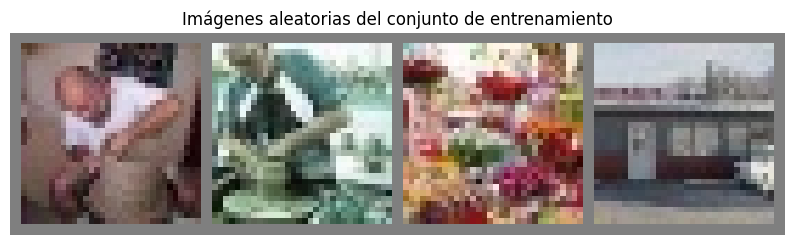

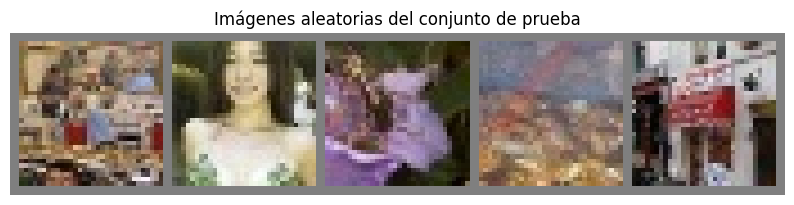

In [38]:
# Función para mostrar imágenes sin clasificación
def show_random_images(loader, num_images=5, title="Imágenes aleatorias del dataset"):
    dataiter = iter(loader)
    images, _ = next(dataiter)
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()

    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Probar la función con conjuntos de datos
show_random_images(train_loader, title="Imágenes aleatorias del conjunto de entrenamiento")
show_random_images(test_loader, title="Imágenes aleatorias del conjunto de prueba")

In [42]:
from IPython.display import display, clear_output
import pandas as pd

# Función de entrenamiento con impresión en columnas
def train(epochs=10):
    model.train()  # Establecer el modelo en modo de entrenamiento
    
    # Listas para almacenar métricas
    epoch_list = []
    train_loss_list = []
    train_acc_list = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Entrenar por lotes
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Reiniciar gradientes
            optimizer.zero_grad()

            # Forward, backward y optimización
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calcular métricas
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calcular métricas por época
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        
        # Almacenar métricas
        epoch_list.append(epoch + 1)
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)
        
        # Mostrar resultados actualizados en columnas
        metrics_table = pd.DataFrame({
            "Época": epoch_list,
            "Pérdida": train_loss_list,
            "Precisión (%)": train_acc_list
        })
        
        clear_output(wait=True)  # Limpiar salida previa
        display(metrics_table)  # Mostrar tabla con resultados

    print("Entrenamiento completado")
    return epoch_list, train_loss_list, train_acc_list

In [43]:
# Entrenar el modelo y mostrar los resultados en columnas
epochs, loss_history, acc_history = train(epochs=10)

,Época,Pérdida,Precisión (%)
0,1,2.034270,28.4500
1,2,1.685752,41.8125
2,3,1.388944,53.3875
3,4,1.104746,64.4000
4,5,0.821959,73.5000
5,6,0.628851,80.1125
6,7,0.466425,85.4250
7,8,0.333624,89.7875
8,9,0.270997,91.5500
9,10,0.223768,93.1250


Entrenamiento completado


In [44]:
# Función para evaluar el modelo en el conjunto de prueba
def evaluate():
    model.eval()  # Cambiar al modo de evaluación
    correct = 0
    total = 0

    # Realizar predicciones sin calcular gradientes
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluando"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Obtener predicciones
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")
    return accuracy

# Llamar a la función de evaluación
print("\n--- EVALUANDO MODELO EN CONJUNTO DE PRUEBA ---")
test_accuracy = evaluate()


--- EVALUANDO MODELO EN CONJUNTO DE PRUEBA ---


Evaluando: 100%|██████████| 400/400 [00:26<00:00, 15.17it/s]

Precisión en el conjunto de prueba: 75.20%


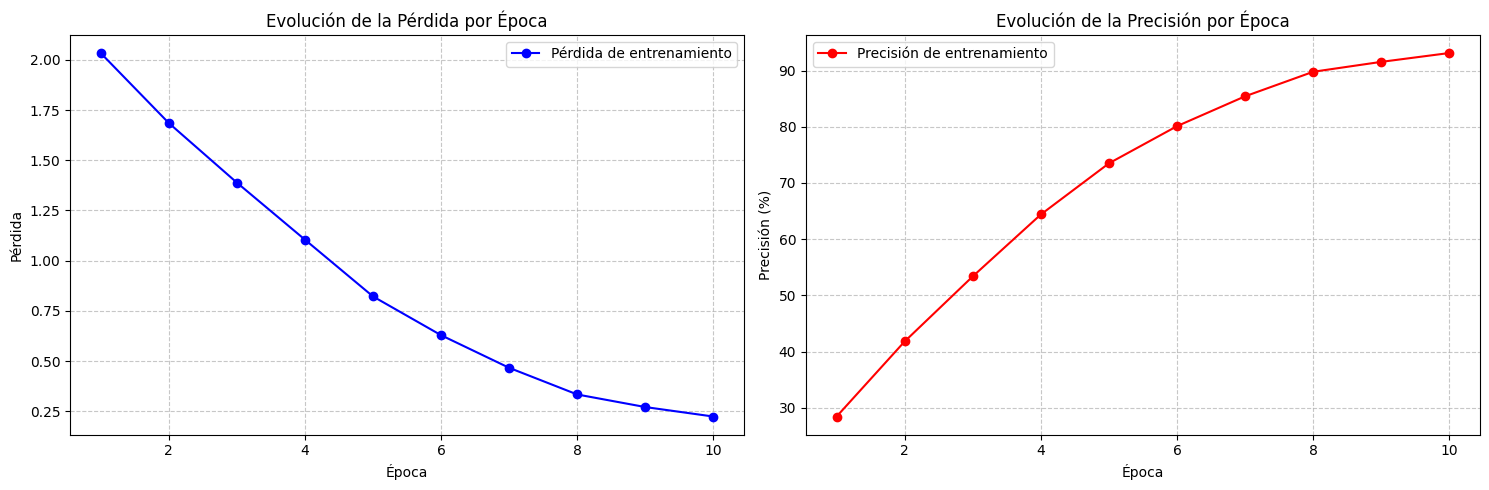

In [45]:
# Función para graficar el progreso del entrenamiento
def plot_training_progress(epochs, loss, accuracy):
    # Crear la figura con dos subgráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico de pérdida por época
    ax1.plot(epochs, loss, marker='o', color='blue', label='Pérdida de entrenamiento')
    ax1.set_title('Evolución de la Pérdida por Época')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Pérdida')
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()
    
    # Gráfico de precisión por época
    ax2.plot(epochs, accuracy, marker='o', color='red', label='Precisión de entrenamiento')
    ax2.set_title('Evolución de la Precisión por Época')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Precisión (%)')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()
    
    # Ajustar el diseño de los gráficos
    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_training_progress(epochs, loss_history, acc_history)


--- MOSTRANDO CLASIFICACIÓN DE IMÁGENES ---


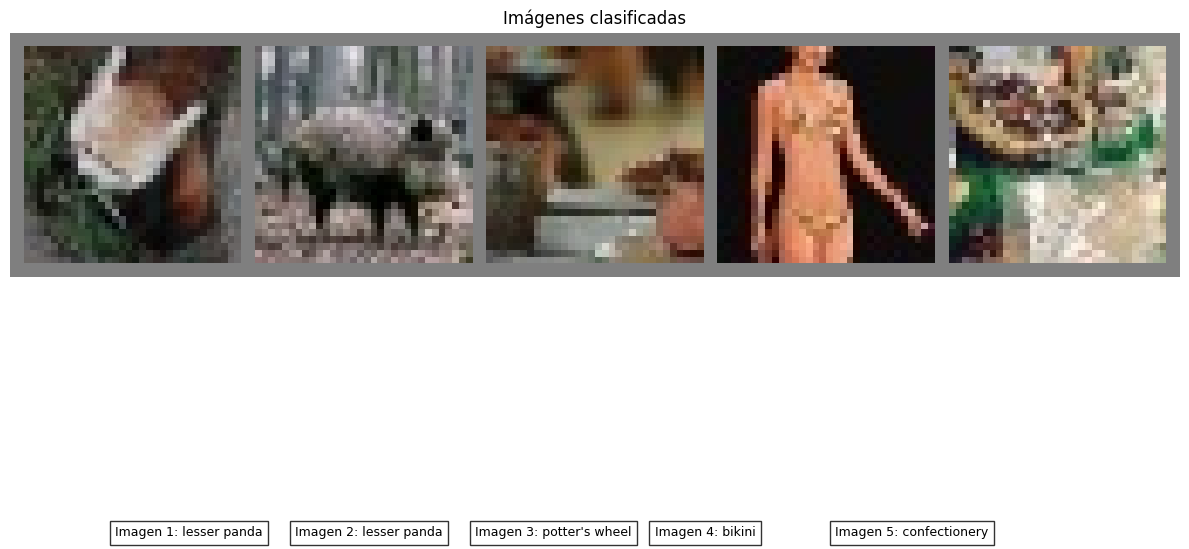

In [47]:
# Función para mostrar imágenes con sus predicciones
def show_classified_images(model, loader):
    model.eval()  # Establecer el modelo en modo de evaluación
    dataiter = iter(loader)
    images, _ = next(dataiter)  # Obtener imágenes sin etiquetas reales

    # Realizar las predicciones
    with torch.no_grad():
        outputs = model(images.to(device))  # Pasar imágenes al modelo
        _, predicted = torch.max(outputs, 1)  # Obtener índices de las clases predichas

    predicted_cpu = predicted.cpu()  # Mover las predicciones a la CPU

    # Desnormalizar las imágenes para visualización
    img = torchvision.utils.make_grid(images)
    img = img / 2 + 0.5
    npimg = img.numpy()

    # Mostrar las imágenes
    plt.figure(figsize=(12, 7))
    plt.title("Imágenes clasificadas")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    # Añadir predicciones como etiquetas debajo de cada imagen
    for i in range(len(images)):
        pred_idx = predicted_cpu[i].item()  # Índice de la clase predicha
        pred_code = index_to_code[pred_idx]  # Código de clase mapeado
        pred_desc = class_descriptions[pred_code].split(',')[0]  # Primera descripción de la clase
        plt.figtext(0.1 + (i % 5) * 0.15, 0.02, f"Imagen {i+1}: {pred_desc}",
                    fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)  # Ajustar espacio inferior para etiquetas
    plt.show()

# Llamar a la función para probar
print("\n--- MOSTRANDO CLASIFICACIÓN DE IMÁGENES ---")
show_classified_images(model, test_loader)

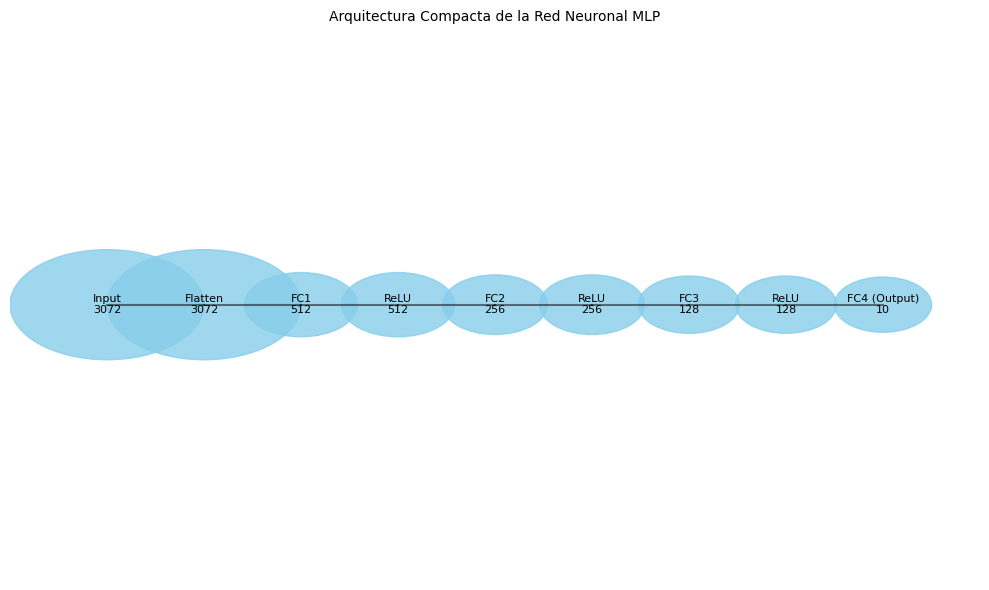

In [58]:
# Visualizar arquitectura con tamaños proporcionales y círculos más pequeños
def visualize_network_architecture_compact(model):
    plt.figure(figsize=(10, 6))  # Tamaño de la figura ajustado

    # Definir las capas de la arquitectura del modelo
    layers = [
        ('Input', 3 * 32 * 32),
        ('Flatten', 3072),
        ('FC1', 512),
        ('ReLU', 512),
        ('FC2', 256),
        ('ReLU', 256),
        ('FC3', 128),
        ('ReLU', 128),
        ('FC4 (Output)', 10)
    ]

    num_layers = len(layers)
    layer_positions = np.linspace(0.1, 0.9, num_layers)

    # Reducir el tamaño general de los círculos manteniendo proporciones
    max_size = max(layer[1] for layer in layers)  # Obtener el tamaño máximo de las capas
    scale_factor = 0.05  # Factor reducido para hacer los círculos más compactos

    for i, (layer_name, layer_size) in enumerate(layers):
        x_pos = layer_positions[i]
        radius = scale_factor + (layer_size / max_size) * scale_factor  # Ajustar el tamaño en base al factor reducido
        circle = plt.Circle((x_pos, 0.5), radius, color='skyblue', alpha=0.8)
        plt.gca().add_patch(circle)
        plt.text(x_pos, 0.5, f"{layer_name}\n{layer_size}", ha='center', va='center', fontsize=8)

        # Dibujar conexiones entre las capas
        if i > 0:
            prev_x = layer_positions[i - 1]
            plt.plot([prev_x, x_pos], [0.5, 0.5], 'k-', alpha=0.5)

    # Configuración del gráfico
    plt.title("Arquitectura Compacta de la Red Neuronal MLP", fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')  # Ocultar ejes para claridad
    plt.tight_layout()
    plt.show()

# Llamar a la función para probar
visualize_network_architecture_compact(model)